In [50]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

%matplotlib inline

In [9]:
with open("secret.txt") as f:
    secret_ls = f.readlines()
    cid = secret_ls[0][:-1]
    secret = secret_ls[1]

#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=str(cid), client_secret=str(secret))
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

playlist_link = "https://open.spotify.com/playlist/37i9dQZEVXbNG2KDcFcKOF?si=1333723a6eff4b7f"
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

96bbe9a1de3d4d73b8891e89f2b59aa3
aaa87182c3bd4ddc8b888939b5c91ef9


In [17]:
Collect feature to measure

In [18]:
pprint.pprint(sp.audio_features(track_uris)[0])

{'acousticness': 0.72,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/75FEaRjZTKLhTrFGsfMUXR',
 'danceability': 0.629,
 'duration_ms': 298933,
 'energy': 0.547,
 'id': '75FEaRjZTKLhTrFGsfMUXR',
 'instrumentalness': 0.00314,
 'key': 10,
 'liveness': 0.0604,
 'loudness': -13.123,
 'mode': 0,
 'speechiness': 0.055,
 'tempo': 108.375,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/75FEaRjZTKLhTrFGsfMUXR',
 'type': 'audio_features',
 'uri': 'spotify:track:75FEaRjZTKLhTrFGsfMUXR',
 'valence': 0.197}


In [68]:
instrumentalnesses = [features['instrumentalness'] for features in sp.audio_features(track_uris)]
speechinesses = [features['speechiness'] for features in sp.audio_features(track_uris)]
time_signatures = [features['time_signature'] for features in sp.audio_features(track_uris)]

Text(0, 0.5, 'Song Count')

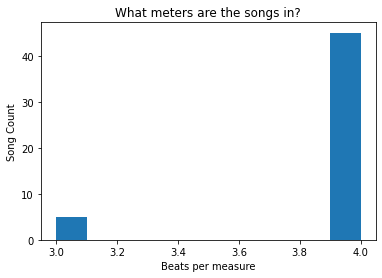

In [69]:
#Create Histogram
fig, ax = plt.subplots(1, 1)
ax.hist(time_signatures)
ax.set_title("What meters are the songs in?")
# adding labels
ax.set_xlabel('Beats per measure')
ax.set_ylabel('Song Count')

Text(0, 0.5, 'Song Count')

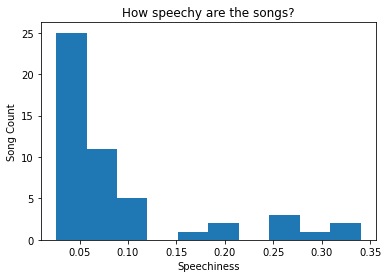

In [71]:
#Create Histogram
fig, ax = plt.subplots(1, 1)
ax.hist(speechinesses)
ax.set_title("How speechy are the songs?")
# adding labels
ax.set_xlabel('Speechiness')
ax.set_ylabel('Song Count')

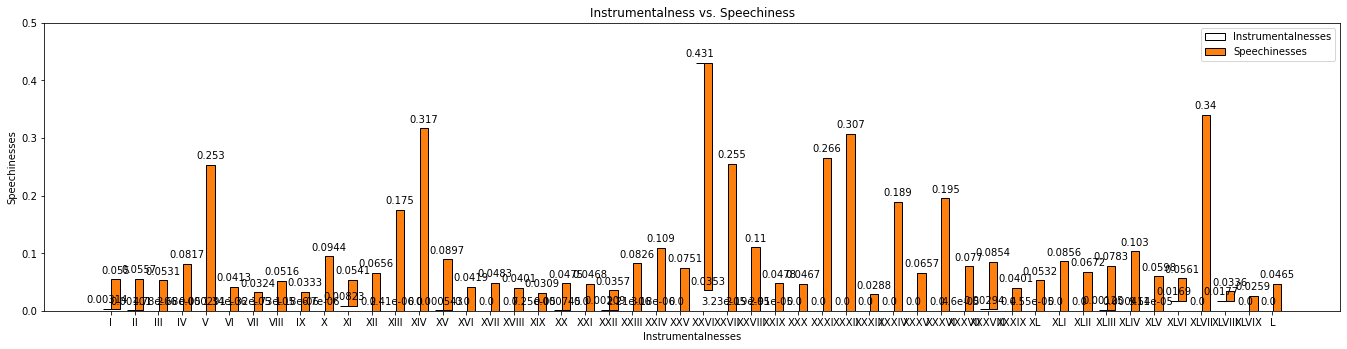

In [47]:
def hat_graph(ax, xlabels, values, group_labels):
    """
    Create a hat graph.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The Axes to plot into.
    xlabels : list of str
        The category names to be displayed on the x-axis.
    values : (M, N) array-like
        The data values.
        Rows are the groups (len(group_labels) == M).
        Columns are the categories (len(xlabels) == N).
    group_labels : list of str
        The group labels displayed in the legend.
    """

    def label_bars(heights, rects):
        """Attach a text label on top of each bar."""
        for height, rect in zip(heights, rects):
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),  # 4 points vertical offset.
                        textcoords='offset points',
                        ha='center', va='bottom')

    values = np.asarray(values)
    x = np.arange(values.shape[1])
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    spacing = 0.3  # spacing between hat groups
    width = (1 - spacing) / values.shape[0]
    heights0 = values[0]
    for i, (heights, group_label) in enumerate(zip(values, group_labels)):
        style = {'fill': False} if i == 0 else {'edgecolor': 'black'}
        rects = ax.bar(x - spacing/2 + i * width, heights - heights0,
                       width, bottom=heights0, label=group_label, **style)
        label_bars(heights, rects)

xlabels = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV',
          'XVI', 'XVII', 'XVIII', 'XIX', 'XX', 'XXI', 'XXII', 'XXIII', 'XXIV', 'XXV', 'XXVI', 'XXVII', 'XXVIII',
          'XXIX', 'XXX', 'XXXI', 'XXXII', 'XXXIII', 'XXXIV', 'XXXV', 'XXXVI', 'XXXVII', 'XXXVIII', 'XXXIX', 'XL',
          'XLI', 'XLII', 'XLIII', 'XLIV', 'XLV', 'XLVI', 'XLVII', 'XLVIII', 'XLVIX', 'L']

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 3.0, 1.0])
hat_graph(ax, xlabels, [instrumentalnesses, speechinesses], ['Instrumentalnesses', 'Speechinesses'])
ax.set_xlabel('Instrumentalnesses')
ax.set_ylabel('Speechinesses')
ax.set_ylim(0, .5)
ax.set_title('Instrumentalness vs. Speechiness')
ax.legend()

